![banner](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/rl_banner.png?raw=true)

# Deterministic Policy Gradients

Deterministic Policy Gradients make one crucial change. What if our Policy was not a distribution over the actions we could take, but rather a single action. This is especially useful in methods like continuous control. In settings like robotic control, where our controller has to output real valued numbers (vehicle throttle, actuators, etc...) this is crucial as our action space is no longer some discrete decision from a set of potential actions. 

### Recap (Stochastic) Policy Gradients

In every example we have looked at until now, our action space was a discrete space. In the FrozenLake games, the agent could go Up/Down/Left/Right. In our LunarLander, the agent could Do Nothing, Fire Left Thruster, Fire Right Thruster, Fire Main Thruster. So when using Policy Networks (as we saw in our derivation [here on the Policy Gradient Theorem](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Policy%20Networks%20(REINFORCE)/policy_networks.ipynb)) we got the following:

$$J(\theta) = \sum_{s}d_\pi(s)\sum_{a}\pi_\theta(a|s)Q_\pi(s,a)$$

Notice the sum over the action space? That was how we essentially weighted our Q values by the policy probabilities. But if we don't want that anymore, where our policy outputs a specific action for a state, rather than a distribution of possible actions for a state, we can start to simplify this a bit!

### DPG Derivation

First step is, we no longer have some distribution over the actions, so lets define the following value function:

$$V_{\mu}(s) = Q^{\mu}(s, \mu_{\theta}(s))$$

Where $\mu$ picks one action deterministically. Then we can write:

$$J(\theta) = \sum_{s}d_\mu(s)V_{\mu}(s) = \sum_{s}d_\mu(s)Q^{\mu}(s, \mu_{\theta}(s))$$

Thus that inner sum is now gone! Remember also that $d_\mu(s)$ was our stationary distribution (just like $d_\pi(s)$ from before) and $Q^{\mu}(s, \mu_{\theta}(s))$ is still our discounted expected return for some action $a$ taken at state $s$. So lets now take the derivative just as we had done before in our Policy Gradient Theorem!

$$\nabla_\theta V_{\mu}(s) = \nabla_\theta Q^{\mu}(s, \mu_{\theta}(s))$$

There are two contributions for this derivative since $Q^{\mu}(s, \mu_{\theta}(s))$ directly depends on $\theta$ the parameters of our model and indirectly in $\mu_{\theta}$. So we can write the following:

$$\nabla_\theta Q^\mu(s, \mu_\theta(s)) = \left[\nabla_a Q^\mu(s, a) \cdot \nabla_\theta \mu_\theta(s) + \frac{\partial}{\partial \theta} Q^\mu(s, a) \right]_{a=\mu_\theta(s)}$$

The first term captures how a change in $\theta$ affected the Q-Value by changing the action chosen by the policy $\mu_\theta(s)$ (standard chain rule). The second term captures the direct effect of $\theta$ on the Q-Values holding the action a fixed at some $a = \mu_\theta(s)$ w.r.t the policy $\mu$. This second term is due to the recursive nature of Q as future actions in the Q-Values expectations depend on $\mu_\theta$.

Lets write out the recursion then! Remember from our Bellman Equation that:

$$Q^\mu(s,a) = \sum_{s',r} P(s',r|s,a) [r + \gamma V_\mu(s')]$$

So that indirect derivative would be the following:

$$\nabla_\theta Q^\mu(s,a) = \sum_{s',r} P(s',r|s,a) \gamma \nabla_\theta V_\mu(s')$$

We can then plug this back into our total derivative from before:

$$\nabla_\theta V_\mu(s) = \nabla_a Q^\mu(s, a) \bigg|_{a=\mu_\theta(s)} \cdot \nabla_\theta \mu_\theta(s) + \sum_{s'} P(s'|s, \mu_\theta(s)) \gamma \nabla_\theta V_\mu(s')$$

And like before, we have a recursive function! Notice how the derivative for the current state $\nabla_\theta  V_\mu(s)$ depends on the derivative of the next state $\nabla_\theta  V_\mu(s')$ For shorthand, lets say that:

$$\phi(s) = \nabla_a Q^\mu(s, a) \bigg|_{a=\mu_\theta(s)} \cdot \nabla_\theta \mu_\theta(s)$$

We can then unroll this expression to find the relationship:

$$\nabla_\theta V_\mu(s) = \phi(s) + \sum_{s'} P(s'|s, \mu_\theta(s)) \gamma \nabla_\theta V_\mu(s')$$
$$ = \phi(s) + \sum_{s'} P(s'|s, \mu_\theta(s)) \gamma \left[ \phi(s') + \sum_{s''} P(s''|s', \mu_\theta(s')) \gamma \right]$$
$$= \phi(s) + \gamma \sum_{s'} P(s'|s, \mu_\theta(s)) \phi(s') + \gamma^2 \sum_{s'} \sum_{s''} P(s'|s, \mu_\theta(s)) P(s''|s', \mu_\theta(s')) \nabla_\theta V_\mu(s'')$$

We can keep unrolling this as much as we want, and as long as $\gamma$ is between 0 and 1 this will converge! Now, our goal again is to compute that stationary distribution without actually computing it (as that would require just roaming around the game for a long time which is impractical). So just like we did in the Policy Gradient Derivation, lets setup an expression that tells us the probability of reaching some state $x$ from a starting state $s$ in $k$ steps under policy $\mu$

The notation was as follows. A 1 step transition from $s$ to $s'$ is written like:

$$\rho_\mu(s \to s', 1) = P(s'|s, \mu_\theta(s))$$

Similarly, if we want k steps, then we can write:

$$\rho_\mu(s \to x, k) = \sum_{s'} \rho_\mu(s \to s', k-1) \rho_\mu(s' \to x, 1) = \sum_{s'} \rho_\mu(s \to s', k-1) P(x|s', \mu_\theta(s'))$$

Which invovles going to any state $s'$ in $k-1$ steps and then going to our target state $x$ in in one step. Doesnt this look like our expression above?
In the expression: 

$$= \phi(s) + \gamma \sum_{s'} P(s'|s, \mu_\theta(s)) \phi(s') + \gamma^2 \sum_{s'} \sum_{s''} P(s'|s, \mu_\theta(s)) P(s''|s', \mu_\theta(s')) \nabla_\theta V_\mu(s'')$$

If we look at the last term:

$$\gamma^2 \sum_{s'} \sum_{s''} P(s'|s, \mu_\theta(s)) P(s''|s', \mu_\theta(s')) \nabla_\theta V_\mu(s'')$$

This is like a 2 step transition from $s$ to some $s''$. So why not use our notation for that (where we sum over all possible middle states $s'$:

$$\gamma^2 \sum_{s''} \rho_\mu(s \to s'', 2) \nabla_\theta V_\mu(s'')$$

So combining all the terms, we can write our final expression as:

$$\nabla_\theta J(\theta) = \nabla_\theta V_\mu(s) = \sum_{x \in S} \sum_{k=0}^\infty \gamma^k \rho_\mu(s \to x, k) \phi(x)$$

Again as shorthand lets set  $\eta(s) = \sum_{k=0}^\infty \gamma^k \rho_\mu(s_0 \to s, k)$, so the expression is now:

$$\nabla_\theta J(\theta) = \sum_{s \in S} \eta(s) \phi(s)$$

Now $\eta(s)$ is an accumulation of transition probabilities over infinitely long trajectories, but it would be helpful if we could normalize $\eta(s)$ to be a probability distribution over the states. We can easily normalize it!

$$\nabla_\theta J(\theta) = \left( \sum_{s \in S} \eta(s) \right) \sum_{s \in S} \frac{\eta(s)}{\sum_{s' \in S} \eta(s')} \phi(s) \propto \sum_{s \in S} d_\mu(s) \phi(s)$$

Here, $\frac{\eta(s)}{\sum_{s'} \eta(s')}$ is exactly the (discounted) stationary distribution $d_\mu(s)$, as it normalizes the accumulated visitation probabilities over infinite trajectories under $\mu$.

Substitute back $\phi(s)$:
$$\nabla_\theta J(\theta) \propto \sum_s d_\mu(s) \left[ \nabla_a Q^\mu(s, a) \cdot \nabla_\theta \mu_\theta(s) \right]_{a=\mu_\theta(s)}$$

Which is finally:

$$\mathbb{E}_{s \sim d_\mu} \left[ \nabla_a Q^\mu(s, a) \cdot \nabla_\theta \mu_\theta(s) \right]_{a=\mu_\theta(s)}$$

Thats it! The derivation was pretty similar to the Policy Gradient setup, we just don't have a distribution over actions anymore!

### Deep Deterministic Policy Gradients

DDPG uses this technique in an Actor-Critic + DQN setup for off policy learning. This means, we will need a replay buffer first (just like we had in DQN!) Lets set that up first:

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from collections import namedtuple, deque
import random
import matplotlib.pyplot as plt
from IPython.display import Video 
import os
from tqdm.notebook import tqdm

class TimeCapsule:
    """
    Simple Class to store and replace memories for continuous action spaces
    """
    def __init__(self, max_memories, num_state_features=2, num_action_features=1):
        self.max_memories = max_memories
        self.current_memories_counter = 0

        # State and next state: [max_memories, num_state_features]
        self.state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)
        self.next_state_memory = torch.zeros((self.max_memories, num_state_features), dtype=torch.float32)

        # Action: [max_memories, num_action_features] for continuous actions
        self.action_memory = torch.zeros((self.max_memories, num_action_features), dtype=torch.float32)

        # Reward: [max_memories]
        self.reward_memory = torch.zeros((self.max_memories,), dtype=torch.float32)

        # Terminal: [max_memories]
        self.terminal_memory = torch.zeros((self.max_memories,), dtype=torch.bool)

    def add_memory(self, state, next_state, action, reward, terminal):
        # Store experience at index using modulo to overwrite oldest memories
        idx = self.current_memories_counter % self.max_memories

        # Store memories as tensors
        self.state_memory[idx] = torch.tensor(state, dtype=torch.float32)
        self.next_state_memory[idx] = torch.tensor(next_state, dtype=torch.float32)
        self.action_memory[idx] = torch.tensor(action, dtype=torch.float32)  # Continuous action
        self.reward_memory[idx] = torch.tensor(reward, dtype=torch.float32)
        self.terminal_memory[idx] = torch.tensor(terminal, dtype=torch.bool)

        # Increment counter
        self.current_memories_counter += 1

    def access_memories(self, batch_size, device="cpu"):
        # Get number of stored memories
        total_memories = min(self.current_memories_counter, self.max_memories)

        if total_memories < batch_size:
            return None

        # Sample random indices
        rand_sample_idx = np.random.choice(total_memories, size=batch_size, replace=False)
        rand_sample_idx = torch.tensor(rand_sample_idx, dtype=torch.long)

        # Return batch of memories
        batch = {
            "states": self.state_memory[rand_sample_idx].to(device),
            "next_states": self.next_state_memory[rand_sample_idx].to(device),
            "actions": self.action_memory[rand_sample_idx].to(device),
            "rewards": self.reward_memory[rand_sample_idx].to(device),
            "terminal": self.terminal_memory[rand_sample_idx].to(device)
        }
        return batch
        

### Actor Model

The actor model is our Policy model for $\mu$. But in this case, we will output a single number. The game we will be playing is the Mountain Car Continuous game, which has just a single scalar value as the action between -1 and 1. Lets make sure our model is the same!

In [20]:
class Actor(nn.Module):
    def __init__(self, 
                 state_dim, 
                 hidden_dim, 
                 action_dim, 
                 max_action=1):
        
        super(Actor, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, hidden_dim//4)
        self.fc4 = nn.Linear(hidden_dim//4, action_dim)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.max_action * torch.tanh(self.fc4(x))

### Critic Model

Our critic model will be a little different than before. In previous methods ([Reinforce w/ Baseline](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/REINFORCE%20with%20Baseline/reinforce_with_baseline.ipynb), [Vanilla Actor Critic](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Reinforcement%20Learning/Deep%20RL%20Policy%20Models/Vanilla%20Actor%20Critic/actor_critic.ipynb), etc...) the purpose of the Critic model was to estimate the Value of a specific state $V(s)$. But in our case look at our final formulation:

$$\mathbb{E}_{s \sim d_\mu} \left[ \nabla_a Q^\mu(s, a) \cdot \nabla_\theta \mu_\theta(s) \right]_{a=\mu_\theta(s)}$$

We want to take the derivative w.r.t the $Q(s,a)$ function, therefore is an estimate for the value of a state **AND** action pair. We also need to take the derivative of our Critic w.r.t the actions, so that information has to be provided to the model for backpropagation to match what we want. 

#### What about an Advantage Estimate

The main reason we did our Advantage estimate like so:

$$ A(s, a) = Q(s, a) - V(s) $$

Was because we wanted to find out how much better a specific action was compared to the average action in a state. But this really only makes sense in stochastic policies and we had a distribution over the possible actions available to us at every state. Now we just have a deterministic (single value) that represents our action. So there is no need to sample actions from a distribution or compare against some baseline $V(s)$. We can instead just directly optimize by maximizing our $Q(s,a)$. 



In [21]:
class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, action_dim)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Action Space Exploration

Because our policy is now deterministic, we have a bit of an issue. When does our model explore? The Exploration vs Exploitation is the most imporant part of training to get to successful results, but as of now everything is deterministic. This means our model can exploit the same action repeatedly and get stuck in a suboptimal policy. 

There are a few options we could pick from to help with this! First, keep in mind, our action is some value between -1 and 1 for this game.

- Random sample a number between -1 and 1 using our standard epsilon-greedy method.
    - Our actions happen over time, this will lead to very abrupt changes
- Random sample some gaussiain noise and add it to our action
    - Provides random exploration, **BUT** lacks some temporal correlation and jerkier action sequences
 
#### Temporal Correlation is Necessary

Lets think about it this way. In our game 1 is full throttle drive forward, and -1 is full throttle dive backward. Isn't there some strong autocorrelation between how we drive? Is it a good idea to throttle forward and then immediately backward for the next step, and then forward again? Of course not, that would be a super jerky ride!!

### Ornstein-Uhlenbeck Process (OU Noise)

OU Noise (read more at [this](https://www.quantstart.com/articles/ornstein-uhlenbeck-simulation-with-python/) link!) is a continuous time stochastic process with a couple of really cool properties:

1) Mean Reversion: Over the long term, the process returns back to the mean $\mu$ that you set
2) Volatility: You can control the randomness of the process with the $\sigma$ parameter
3) Speed of Reversion: You can control how fast it returns to the mean with the $\theta$ parameter
4) Stationary: The statistics of the process do not change over time!

This is typically written as:

$$dx_t = \theta (\mu-x_t)dt + \sigma dW_t$$

Where $W_t$ is some [Weiner Process](https://en.wikipedia.org/wiki/Wiener_process) (aka Brownian Motion). The main  thing we care about the Weiner Process is that increments $W_t - W_s$ for any $s < t$ is independent of the past **AND** Gaussian with the distribution $W_t - W_s \sim N(0, t-s)$. Now because we are working on computers, $t$ can't be come continuous number, so we have to discretize. In our case $t$ is the step of the game we are on, so its easiest to just say that our smallest increment $\Delta t$ is just 1 (unit timestep). That means $W_t - W_s \sim N(0, 1)$ for $t - s = 1$. 


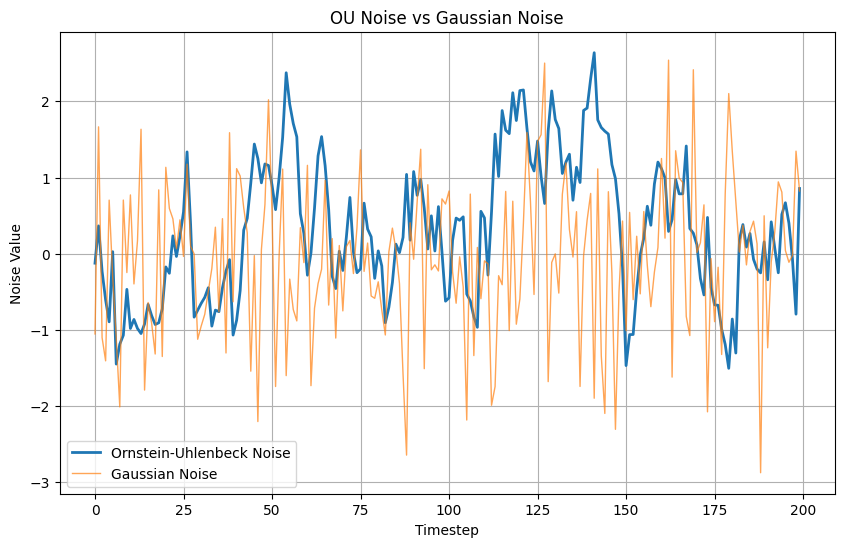

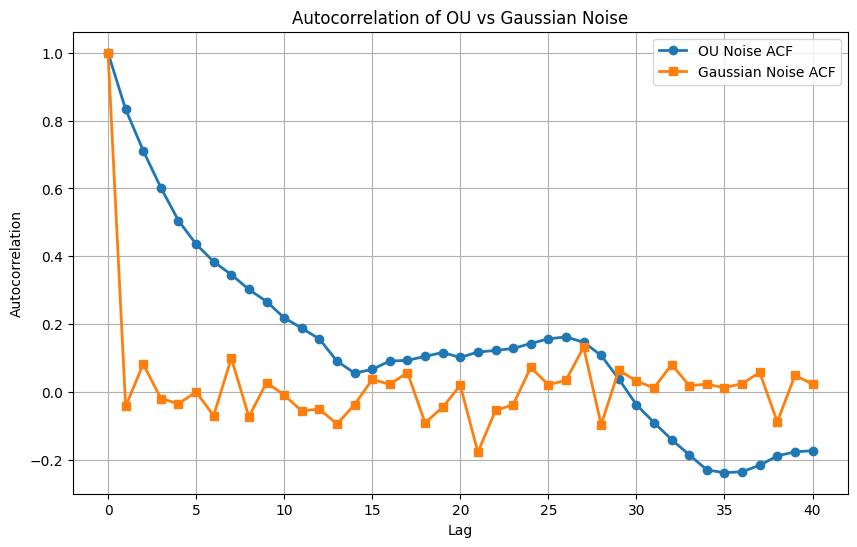

In [22]:
from statsmodels.tsa.stattools import acf

class OUNoise:
    def __init__(self, action_dim, mu=0.0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dim) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

# Parameters
timesteps = 200
action_dim = 1

# Create OU noise generator
ou_noise = OUNoise(action_dim=action_dim, mu=0.0, theta=0.15, sigma=0.5)

# Collect samples
ou_samples = []
gaussian_samples = []

for t in range(timesteps):
    ou_samples.append(ou_noise.sample()[0])
    gaussian_samples.append(np.random.randn())

# Plot
plt.figure(figsize=(10, 6))
plt.plot(ou_samples, label="Ornstein-Uhlenbeck Noise", linewidth=2)
plt.plot(gaussian_samples, label="Gaussian Noise", linewidth=1, alpha=0.7)
plt.title("OU Noise vs Gaussian Noise")
plt.xlabel("Timestep")
plt.ylabel("Noise Value")
plt.legend()
plt.grid(True)
plt.show()

# Compute autocorrelation for OU and Gaussian samples
ou_acf = acf(ou_samples, nlags=40, fft=True)
gaussian_acf = acf(gaussian_samples, nlags=40, fft=True)

# Plot autocorrelation comparison
plt.figure(figsize=(10, 6))
plt.plot(ou_acf, marker="o", label="OU Noise ACF", linewidth=2)
plt.plot(gaussian_acf, marker="s", label="Gaussian Noise ACF", linewidth=2)
plt.title("Autocorrelation of OU vs Gaussian Noise")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.legend()
plt.grid(True)
plt.show()

### Train our DDPG

Training our model wont be all that different from everything else! There are two main changes we need to make:

1) Add the OU noise to sampled actions to ensure our Replay Buffer contains a diverse range of state/action pairs.
2) Soft Target updates. In our Double-DQN, we had a target network that was essentially a lagged copy of our actual model. Typically we just leave this model frozen for a few iterations to avoid the moving-target issue, but in the DDPM paper, they do soft updates to slowly update the lagged model rather than just have it catch up every few iterations (hard update).

#### Soft Update Form

$$\theta_{\text{target}} \leftarrow \tau \theta + (1 - \tau) \theta_{\text{target}}$$

In [23]:
class DDPG:
    def __init__(self, state_dim, hidden_dim, action_dim, max_action, lr=0.001, gamma=0.99, tau=0.001, batch_size=128, max_memories=1000000):
        self.actor = Actor(state_dim, hidden_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, hidden_dim, action_dim, max_action)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)

        self.critic = Critic(state_dim, hidden_dim, action_dim)
        self.critic_target = Critic(state_dim, hidden_dim, action_dim)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)

        self.lr = lr
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.max_memories = max_memories
        self.replay_buffer = TimeCapsule(max_memories=max_memories, num_state_features=state_dim, num_action_features=action_dim)
        self.noise = OUNoise(action_dim)
        self.max_action = max_action

    def select_action(self, state, noise=True):

        ### Grab State and Sample Action ###
        state = torch.from_numpy(state).float().unsqueeze(0)
        action = self.actor(state).detach().numpy()[0]
        
        ### When training add some noise! ###
        if noise:
            action += self.noise.sample()
            
        return np.clip(action, -self.max_action, self.max_action)

    def update(self):

        ### Grab a Batch ###
        batch = self.replay_buffer.access_memories(self.batch_size)
        if batch is None:
            return

        ### Grab Experience Tuples ###
        states = batch["states"]  # [batch_size, state_dim]
        actions = batch["actions"]  # [batch_size, action_dim]
        rewards = batch["rewards"].unsqueeze(-1)  # [batch_size, 1]
        next_states = batch["next_states"]  # [batch_size, state_dim]
        dones = batch["terminal"].float().unsqueeze(-1)  # [batch_size, 1]
        

        ### Update Critic (use target models that are lagged for more stable estimates) for Q(s', a') ###
        self.critic_optimizer.zero_grad()
        with torch.no_grad():
            next_actions = self.actor_target(next_states)  # [batch_size, action_dim]
            target_q = self.critic_target(next_states, next_actions)  # [batch_size, action_dim]
            target_q = rewards + (1 - dones) * self.gamma * target_q  # [batch_size,]

        current_q = self.critic(states, actions)  # [batch_size,]
        critic_loss = F.mse_loss(current_q, target_q)
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor update (using DPG gradient) ###
        self.actor_optimizer.zero_grad()
        actor_actions = self.actor(states)
        actor_loss = -self.critic(states, actor_actions).mean()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Soft target updates
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

### Train and Evaluate Model

Training loop is pretty straight forward, not all that different from our DQN training loop from before!

In [26]:
# Training Loop
def train_ddpg(env_name='MountainCarContinuous-v0', 
               episodes=100, 
               max_steps=999,
               hidden_dim=256,
               print_freq=50,
               max_memories=1000000,
               lr=0.001, 
               gamma=0.99, 
               tau=0.001, 
               batch_size=128):
    
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])
    agent = DDPG(state_dim, hidden_dim, action_dim, max_action, lr=lr, gamma=gamma, tau=tau, batch_size=batch_size, max_memories=max_memories)

    rewards = []
    for episode in tqdm(range(episodes), total=episodes):
        state, _ = env.reset()
        agent.noise.reset()
        episode_reward = 0
        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            agent.replay_buffer.add_memory(state, next_state, action, reward, done)
            agent.update()
            state = next_state
            episode_reward += reward
            if done:
                break
        rewards.append(episode_reward)

        if episode % print_freq == 0:
            print(f"Episode {episode + 1}: Reward = {episode_reward}")

    env.close()
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('DDPG Training on MountainCarContinuous')
    plt.show()
    plt.close()

    return agent

def record_game(env_name='MountainCarContinuous-v0', 
                policy=None, 
                prefix='ddpg-mountaincar', 
                device='cpu', 
                max_steps=1000,
                hidden_dim=256):
    """
    Run an episode with the trained policy and record a video.
    """
    env = gym.make(env_name, render_mode='rgb_array')
    env = gym.wrappers.RecordVideo(
        env,
        video_folder="./savevideos",
        video_length=0,
        disable_logger=True,
        name_prefix=prefix
    )

    done = False
    state, _ = env.reset()
    episode_reward = 0
    step = 0

    while not done and step < max_steps:
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            action = policy(state_tensor).cpu().numpy()[0]
        action = np.clip(action, -float(env.action_space.high[0]), float(env.action_space.high[0]))
        new_state, reward, terminal, truncate, _ = env.step(action)
        done = terminal or truncate
        state = new_state
        episode_reward += reward
        step += 1

    print(f"Inference Episode Reward: {episode_reward}")
    env.close()

    video_path = f"./savevideos/{prefix}-episode-0.mp4"
    return video_path

### Mountaincar Game 


  0%|          | 0/100 [00:00<?, ?it/s]

Episode 1: Reward = -15.49389152983652
Episode 6: Reward = -41.380471256573294
Episode 11: Reward = -21.019536323442217
Episode 16: Reward = -16.699978542417643
Episode 21: Reward = 85.90788606592166
Episode 26: Reward = 90.67141597529869
Episode 31: Reward = 91.58967707131409
Episode 36: Reward = 66.5256643024823
Episode 41: Reward = -48.42337670021453
Episode 46: Reward = 94.2175675150295
Episode 51: Reward = 92.22942015853118
Episode 56: Reward = 94.16951661520238
Episode 61: Reward = 94.3111066350827
Episode 66: Reward = 95.35285449640017
Episode 71: Reward = 95.12845808603205
Episode 76: Reward = 93.8924615355649
Episode 81: Reward = 92.38122435824212
Episode 86: Reward = 94.82946087445904
Episode 91: Reward = 94.53639477047041
Episode 96: Reward = 91.72259521726339


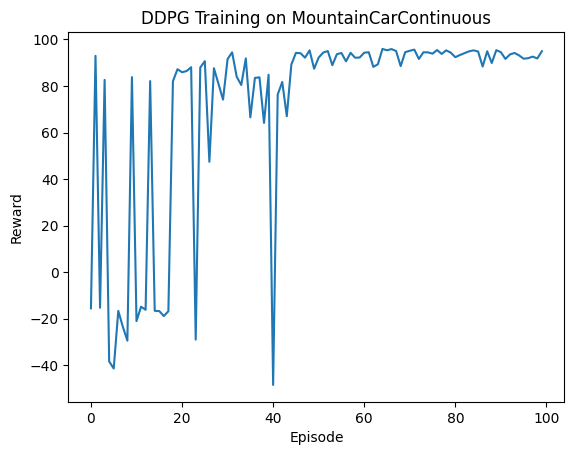

/home/priyam/anaconda3/envs/torch/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /mnt/analysisdrive/analysis/NCSA_HAL_Tutorials/PyTorch for Reinforcement Learning/Continuous Control/DDPG/savevideos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Inference Episode Reward: 94.39937513592022


In [27]:
agent = train_ddpg(episodes=100, print_freq=5, max_memories=100000, hidden_dim=128)
agent.actor.eval()
video_path = record_game(policy=agent.actor, device='cpu')
Video(video_path, embed=True)